## Regression Prediction and Customer Segmentation

Latar belakang kasus:
Sebagai seorang Data Scientist di Kalbe Nutritional, tim inventory dan tim marketing memberikan project baru yaitu sebagai berikut.
- Tim Inventory : membuat prediksi jumlah penjualan (quantity) dari total produk yang dijual Kalbe keseluruhan dengan tujuan membantu tim inventory untuk mengetahui perkiraan quantity produk yg terjual untuk memenuhi stok persediaan harian cukup
- Tim Marketing : membuat customer segmentation untuk membantu tim marketing dalam memberikan personalized promotion dan sales treatment

### DATA PREPARATION

In [19]:
#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
#load dataset
cust = pd.read_csv('customer.csv',sep=";")
prod = pd.read_csv('product.csv',sep=";")
store = pd.read_csv('store.csv',sep=";")
trans = pd.read_csv('transaction.csv',sep=";")

In [3]:
cust

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"
...,...,...,...,...,...
442,443,33,1,NaN,"9,28"
443,444,53,0,Married,"15,31"
444,445,51,0,Married,"14,48"
445,446,57,0,Married,"7,81"


In [4]:
prod

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200
5,P6,Cashew,18000
6,P7,Coffee Candy,9400
7,P8,Oat,16000
8,P9,Yoghurt,10000
9,P10,Cheese Stick,15000


In [5]:
store

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"
5,6,Lingga,Lingga,Modern Trade,"-5,135399","119,42379"
6,7,Buana Indah,Buana,General Trade,"3,316694","114,590111"
7,8,Sinar Harapan,Harapan Baru,General Trade,"5,54829","95,323753"
8,9,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
9,10,Harapan Baru,Harapan Baru,General Trade,"3,597031","98,678513"


In [6]:
trans

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4
...,...,...,...,...,...,...,...,...
5015,TR54423,243,31/12/2022,P10,15000,5,75000,3
5016,TR5604,271,31/12/2022,P2,3200,4,12800,9
5017,TR81224,52,31/12/2022,P7,9400,6,56400,9
5018,TR85016,18,31/12/2022,P8,16000,3,48000,13


### DATA PREPROCESSING

In [7]:
# check info dari masing2 dataframe
print("DataFrame Customer info: ", cust.info())
print("DataFrame Product info: ", prod.info())
print("DataFrame Store info: ", store.info())
print("DataFrame Transaction info: ", trans.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB
DataFrame Customer info:  None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes
DataFrame Product info:  None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Col

Terdapat 3 nilai missing value pada dataframe cust yaitu pada kolom Marital Status. Maka 3 nilai missing value akan diisi dengan nilai "Unknown"

In [8]:
# fill missing value
cust['Marital Status'].fillna("Unknown", inplace=True)

In [9]:
#check the missing value
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  447 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB


In [10]:
# change the format before convert to datetime
# convert to datatype
# trans['Date'] : obj to datetime
trans['Date'] = pd.to_datetime(trans['Date'], format = '%d/%m/%Y')

In [11]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TransactionID  5020 non-null   object        
 1   CustomerID     5020 non-null   int64         
 2   Date           5020 non-null   datetime64[ns]
 3   ProductID      5020 non-null   object        
 4   Price          5020 non-null   int64         
 5   Qty            5020 non-null   int64         
 6   TotalAmount    5020 non-null   int64         
 7   StoreID        5020 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 313.9+ KB


In [12]:
#merge all dataframe into 1
df = trans.merge(cust, on='CustomerID') \
                .merge(store, on='StoreID') \
                .merge(prod, on='ProductID')

In [13]:
df

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,StoreName,GroupStore,Type,Latitude,Longitude,Product Name,Price_y
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,"10,53",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,"0,18",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,"4,36",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
3,TR4331,335,2022-01-08,P3,7500,3,22500,12,29,1,Single,"4,74",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
4,TR6445,181,2022-01-10,P3,7500,4,30000,12,33,1,Married,"9,94",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5015,TR47252,190,2022-07-14,P6,18000,1,18000,2,34,1,Married,"8,85",Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238",Cashew,18000
5016,TR13595,268,2022-09-03,P6,18000,4,72000,2,49,1,Single,"5,18",Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238",Cashew,18000
5017,TR92165,365,2022-03-08,P6,18000,3,54000,2,28,0,Single,"6,05",Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238",Cashew,18000
5018,TR27651,15,2022-07-07,P6,18000,3,54000,2,30,0,Married,"4,52",Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238",Cashew,18000


In [14]:
# drop duplicate column
df.drop('Price_y',axis=1,inplace=True)
#rename column
df.rename(columns = {"Price_x":"price",
                    "Marital Status":"marital_status",
                    "Product Name":"product_name"}, inplace=True)

In [15]:
#check df
df

,TransactionID,CustomerID,Date,ProductID,price,Qty,TotalAmount,StoreID,Age,Gender,marital_status,Income,StoreName,GroupStore,Type,Latitude,Longitude,product_name
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,"10,53",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,"0,18",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,"4,36",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers
3,TR4331,335,2022-01-08,P3,7500,3,22500,12,29,1,Single,"4,74",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers
4,TR6445,181,2022-01-10,P3,7500,4,30000,12,33,1,Married,"9,94",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5015,TR47252,190,2022-07-14,P6,18000,1,18000,2,34,1,Married,"8,85",Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238",Cashew
5016,TR13595,268,2022-09-03,P6,18000,4,72000,2,49,1,Single,"5,18",Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238",Cashew
5017,TR92165,365,2022-03-08,P6,18000,3,54000,2,28,0,Single,"6,05",Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238",Cashew
5018,TR27651,15,2022-07-07,P6,18000,3,54000,2,30,0,Married,"4,52",Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238",Cashew


### MACHINE LEARNING

#### Regression (Time Series)

Ketentuan Regression Time Series:

- Goal: prediksi total quantity harian dari produk yang dijual
- Data merge untuk menggabungkan semua data
- Data baru untuk regression: groupby by kolom Date yg diaggregasi SUM dari kolom qty
- Output ada 365 rows
- Metode time series ARIMA

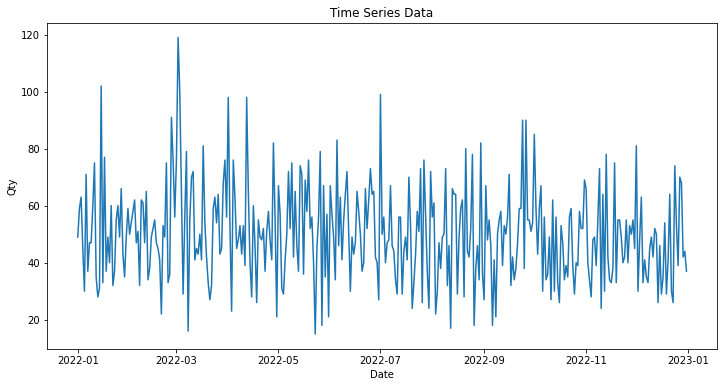

In [21]:
#plot the dataframe
plt.figure(figsize=(12, 6))
plt.plot(df_reg)
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.show()

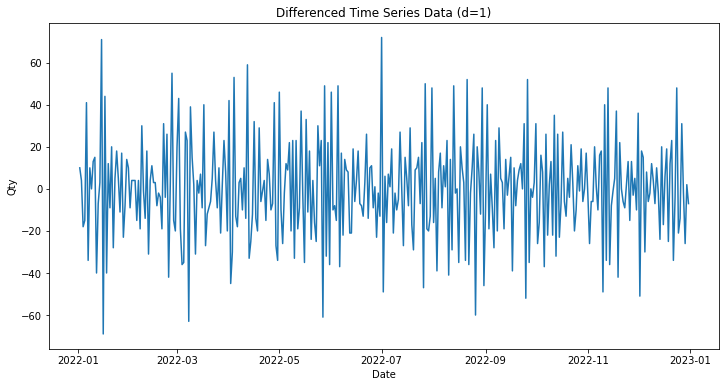

In [23]:
# Differencing the time series data
df_ts_diff = df_ts.diff(periods=1).dropna()

# Plot the differenced time series data
plt.figure(figsize=(12, 6))
plt.plot(df_ts_diff)
plt.title('Differenced Time Series Data (d=1)')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.show()

C:\Users\User\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


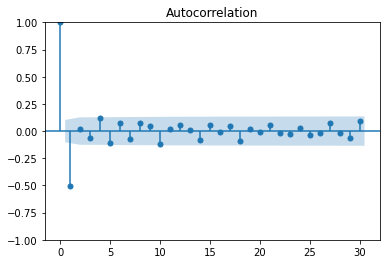

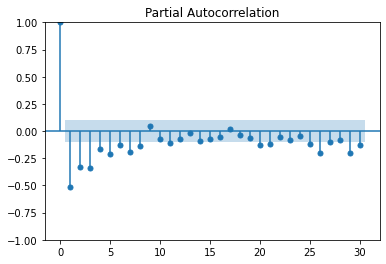

In [16]:
# grouping data by date dan agregat kolom sum(qty)
reg_df = df.groupby('Date')['Qty'].sum()
reg_df

Date
2022-01-01    49
2022-01-02    59
2022-01-03    63
2022-01-04    45
2022-01-05    30
              ..
2022-12-27    70
2022-12-28    68
2022-12-29    42
2022-12-30    44
2022-12-31    37
Name: Qty, Length: 365, dtype: int64

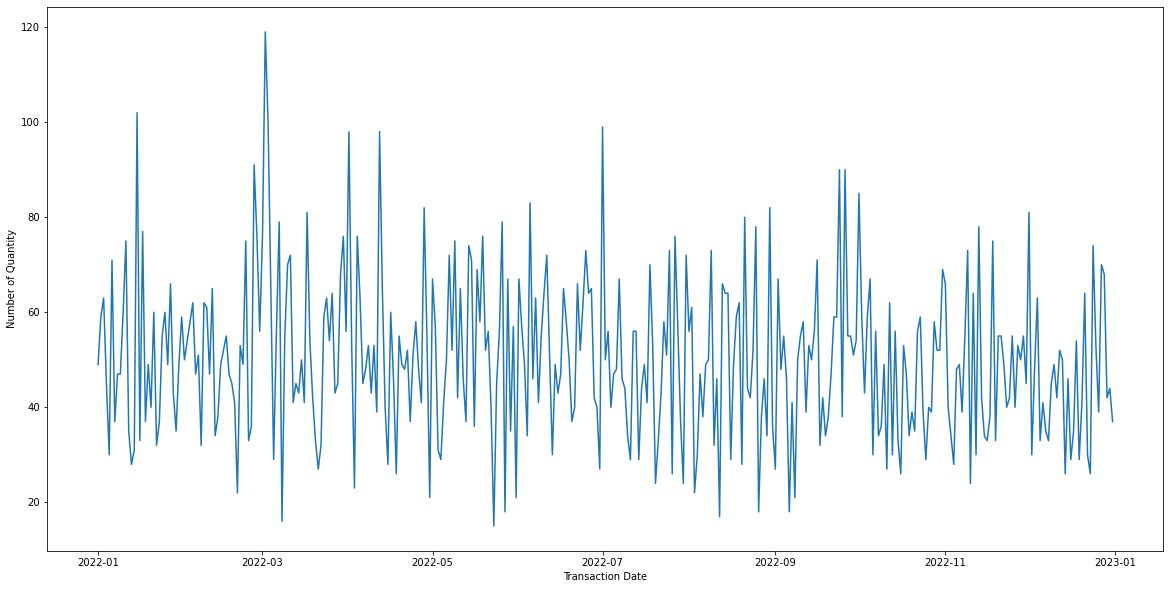

In [17]:
# plot to line chart
#import viz lib
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(reg_df)
plt.xlabel("Transaction Date")
plt.ylabel("Number of Quantity")
plt.show()

In [25]:
# import regression lib
from sklearn.linear_model import LinearRegression
# import lib for time-series method
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

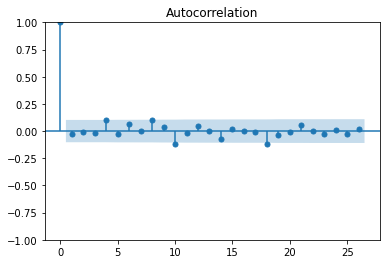

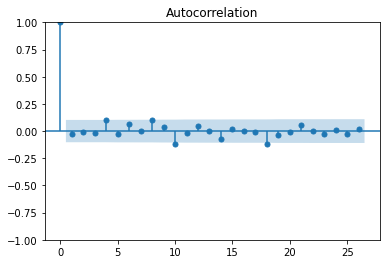

In [22]:
# choosing p,q,d for ARIMA model
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(reg_df)

#### Clustering

Ketentuan Clustering: 

- Goal: membuat cluster customer yang mirip
- Membuat data baru untuk clustering (groupby by kolom customerID dgn kolom yg diagregasi yaitu COUNT(TransactionID), SUM(Qty), SUM(Total Amount))
- Menggunakan metode clustering KMeans

In [27]:
# new dataframe
clust_df = df.groupby('CustomerID').agg({'TransactionID':'count',
                                        'Qty': 'sum',
                                        'TotalAmount':'sum'}).reset_index()

In [28]:
clust_df

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600
...,...,...,...,...
442,443,16,59,485100
443,444,18,62,577700
444,445,18,68,587200
445,446,11,42,423300


In [30]:
# X as feature
X = clust_df[['TransactionID', 'Qty', 'TotalAmount']]

In [31]:
# standardize the X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [34]:
# find the wcss
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


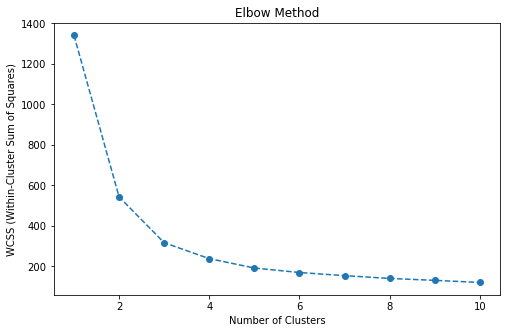

In [35]:
# visualize the 3 variables in scatter plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

In [36]:
optimal_num_clusters = 3  # Adjust this based on your analysis

# Create the K-Means model with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_num_clusters, init='k-means++', random_state=42)

# Fit the K-Means model to the standardized data
kmeans.fit(X_scaled)

KMeans(n_clusters=3, random_state=42)

In [37]:
# Add the cluster labels to the customer data
clust_df['Cluster'] = kmeans.labels_

# Display the resulting customer segments
print(clust_df)

     CustomerID  TransactionID  Qty  TotalAmount  Cluster
0             1             17   60       623300        1
1             2             13   57       392300        1
2             3             15   56       446200        1
3             4             10   46       302500        2
4             5              7   27       268600        0
..          ...            ...  ...          ...      ...
442         443             16   59       485100        1
443         444             18   62       577700        1
444         445             18   68       587200        1
445         446             11   42       423300        2
446         447             13   42       439300        2

[447 rows x 5 columns]


In [38]:
# Assess the quality of the clustering using silhouette score
silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.4286478086768933
